In [1]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import metrics
from sklearn import datasets
import pandas as pd
import numpy as np
#import pandas_profiling as pp
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import random
%matplotlib inline

## Load and Clean Data

In [2]:
# Read in CSV
df = pd.read_csv("final_project.csv")
print(len(df))

160000


In [3]:
# Rename obvious columns
df.rename(columns={'x24': 'continent', 'x29': 'month', 'x30': 'day'}, inplace = True)
#list(df.columns) 

In [4]:
# initialize temp for x37 column
temp_x37 = []

# Remove $ ) , characters and replace '(' with '-' 
for i in range (0,len(df)) :
    try :
        n = df['x37'][i]
        nstr = re.sub(r'[$|,|)]',r'', n)
        nstr = re.sub(r'[(]',r'-',nstr)
        #nstr= float(nstr)
        temp_x37.append(nstr)
    except :
        nstr = ''
        temp_x37.append(nstr)

In [5]:
# Verify len of both x37 matches
print(len(df['x37']))
print(len(temp_x37))

# Replace 'x37' with new values and convert to numeric
df['x37'] = temp_x37
df["x37"] = pd.to_numeric(df["x37"])
df['x37']

160000
160000


0         1313.96
1         1962.78
2          430.47
3        -2366.29
4         -620.66
           ...   
159995    -891.96
159996    1588.65
159997     687.46
159998     439.21
159999   -1229.34
Name: x37, Length: 160000, dtype: float64

In [6]:
# Correct misspellings and standardize values in labeled columns
df['continent'].replace('euorpe', 'europe',inplace=True)
df['month'].replace('Dev', '12',inplace=True)
df['month'].replace('Aug', '8',inplace=True)
df['month'].replace('Jun', '6',inplace=True)
df['month'].replace('Apr', '4',inplace=True)
df['month'].replace('Nov', '11',inplace=True)
df['month'].replace('sept.', '9',inplace=True)
df['month'].replace('Oct', '10',inplace=True)
df['month'].replace('Mar', '3',inplace=True)
df['month'].replace('January', '1',inplace=True)
df['month'].replace('Feb', '2',inplace=True)
df['month'].replace('May', '5',inplace=True)
df['month'].replace('July', '7',inplace=True)
df['month'].replace('December', '12',inplace=True)
df['month'].replace('August', '8',inplace=True)
df['month'].replace('June', '6',inplace=True)
df['month'].replace('April', '4',inplace=True)
df['month'].replace('November', '11',inplace=True)
df['month'].replace('September', '9',inplace=True)
df['month'].replace('October', '10',inplace=True)
df['month'].replace('March', '3',inplace=True)
df['day'].replace('thurday', 'thursday',inplace=True)



# check unique values in labeled columns
print (df['continent'].unique())
print (df['month'].unique())
print (df['day'].unique())

['europe' 'asia' 'america' nan]
['7' '8' '6' '5' '9' '4' '11' '10' nan '3' '2' '12' '1']
['tuesday' 'wednesday' 'thursday' 'monday' 'friday' nan]


In [7]:
#Remove % sign from x32
df['x32']=(df['x32'].str.rstrip('%').astype('float'))

In [8]:
# Testing with complete data set - Drop continent, x41, x6 per EDA suggestion.
# Need to drop continent, day, month, x32 since it's categorical
knn_df = df.drop(['x41', 'x6', 'continent', 'month',  'day','x32'], axis=1)

#Fill NA with mean
knn_df=knn_df.fillna(df.mean())

#Drop any row with NA
knn_df=knn_df.dropna()

In [9]:
knn_df.head()

,x0,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x40,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,-14.789997,-1.040673,-4.204950,6.187465,...,-10.612200,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,-6.725709,0.896421,0.330165,-11.708859,...,2.147427,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,11.060572,5.325880,-2.632984,1.572647,...,-0.863137,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-18.913592,-0.337041,-5.568076,-2.000255,...,12.084421,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,27.532281,1.199715,-4.309105,6.667530,...,30.004727,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


<hr>

# KNN-almost full dataset-K=5
Created a dataset with the following changes

- Used the mean to fill any NAs.
- removed categorical features ('continent', 'month', 'day', 'x32')
- deleted x41 and x6 (per EDA suggestions)
## Accuracy = 80.24%

In [10]:
#Create x and y

y = knn_df['y']
x = knn_df.drop('y', axis = 1)

In [11]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [12]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [13]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
y_pred=classifier.predict(x_test)

In [16]:
#Evaluating Results
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.80240625
[[16470  2642]
 [ 3681  9207]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     19112
           1       0.78      0.71      0.74     12888

    accuracy                           0.80     32000
   macro avg       0.80      0.79      0.79     32000
weighted avg       0.80      0.80      0.80     32000



<hr>

# KNN Loop K=1-25 to find best K value
Created a dataset with the following changes

- dropped any rows with NA
- removed categorical features
- deleted x41 and x6 (per EDA suggestions)
- removed features that had a random forest importance < 0.04
## Best value - K=9

In [150]:
#Subset by RF important features >.04
knn_importance_df = knn_df[['x23', 'x20', 'x48', 'x49', 'x38', 'x12', 'x42', 'x27','x40', 'x37','x28','x7','x2', 'x46', 'y']]


In [151]:
#Create x and y

y = knn_importance_df['y']
x = knn_importance_df.drop('y', axis = 1)

In [181]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1234)

In [182]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [183]:
#source: https://www.ritchieng.com/machine-learning-k-nearest-neighbors-knn/
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.9320625, 0.929125, 0.947, 0.94521875, 0.9496875, 0.948875, 0.95115625, 0.95021875, 0.95171875, 0.9495, 0.95046875, 0.948875, 0.95015625, 0.94971875, 0.95, 0.949375, 0.94990625, 0.9493125, 0.94928125, 0.9486875, 0.94925, 0.9488125, 0.9493125, 0.9486875, 0.94890625]


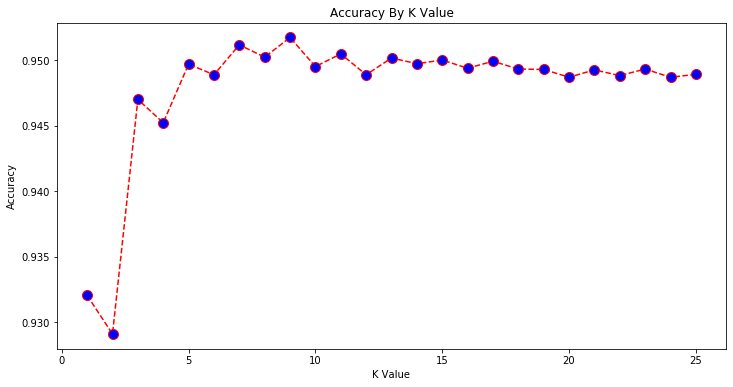

In [184]:
#Visualize it 
# Source: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

plt.figure(figsize=(12, 6))
plt.plot(range(1, 26), scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy By K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.savefig('KNN_Accuracy.png')

<hr> 

# KNN-K=9
Ran model with K=9 per findings from loop above
## Accuracy = 95.17%

In [209]:
#Create x and y

y = knn_importance_df['y']
x = knn_importance_df.drop('y', axis = 1)

In [210]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

In [211]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [212]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=9)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [213]:
y_pred=classifier.predict(x_test)

In [214]:
#Evaluating Results
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.95171875
[[18394   714]
 [  831 12061]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19108
           1       0.94      0.94      0.94     12892

    accuracy                           0.95     32000
   macro avg       0.95      0.95      0.95     32000
weighted avg       0.95      0.95      0.95     32000



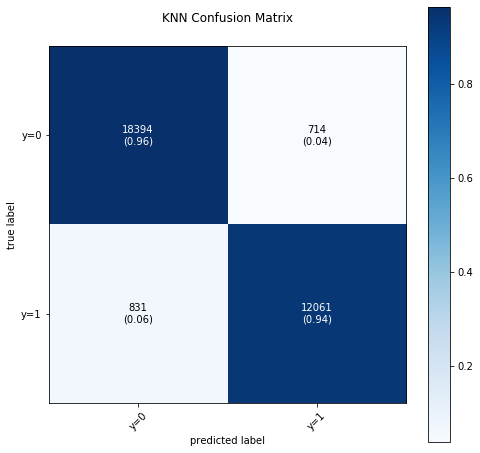

In [191]:
binary = np.array([[18394, 714],
                   [831, 12061]])

class_names = ['y=0', 'y=1']
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               class_names=class_names,
                               figsize=(8,8))
plt.title('KNN Confusion Matrix')
plt.savefig('KNN_Matrix.png')
plt.show()

# Accuracy = 95.17%